In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
# get_ipython().magic(u'matplotlib auto')
import tensorflow as tf
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
# import torch
from tensorflow import keras
import statistics

In [2]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Activation
from tensorflow import reshape
from keras.utils import np_utils
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling1D,AveragePooling1D
from tensorflow.keras.layers import Input, LocallyConnected1D
from tensorflow.keras.layers import SeparableConv1D, Bidirectional
from tensorflow.keras.layers import LocallyConnected2D
from tensorflow.keras.layers import ZeroPadding2D,ZeroPadding1D, MaxPooling2D, Bidirectional
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import CSVLogger,LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [3]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import mean
from numpy import std
# import coremltools
# from torch import nn, optim
# import torch.nn.functional as F
import scipy.io
from scipy import stats
#from IPython.display import display, HTML
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU,SimpleRNN
from tensorflow.keras.layers import TimeDistributed
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

In [4]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(20, 14))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [5]:
# The number of steps within one time segment
TIME_PERIODS = 1500
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 1500
N_FEATURES = 8

In [6]:
column_names = ['C'+str(j) for j in range(1, N_FEATURES+1)]
lst = ['Class_label']
column_names = column_names+lst
print(column_names)

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'Class_label']


In [7]:
def read_data_Train(file_path_Train):
    df_Train = pd.read_csv(file_path_Train,header=None,names=column_names)
    # Last column has a ";" character which must be removed ...
    df_Train['Class_label'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    # ... and then this column must be transformed to float explicitly
    df_Train['Class_label'] = df_Train['Class_label'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df_Train.dropna(axis=0, how='any', inplace=True)
    return df_Train
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [8]:
def show_basic_dataframe_info(dataframe):
    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

In [9]:
def read_data_Test(file_path_Test):
    df_Test = pd.read_csv(file_path_Test,header=None,names=column_names)
    # Last column has a ";" character which must be removed ...
    df_Test['Class_label'].replace(regex=True,inplace=True,to_replace=r';',value=r'')
    # ... and then this column must be transformed to float explicitly
    df_Test['Class_label'] = df_Test['Class_label'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df_Test.dropna(axis=0, how='any', inplace=True)
    return df_Test

In [10]:
 pd.options.display.float_format = "{:,.5f}".format

In [11]:
# 15 function to segment data into trial lengths (trial length =513 samples in this dataset)
def create_segments_and_labels(df, time_steps,step,n_features, label_name):
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
      for j in range(1, n_features+1):
        L = ('C'+str(j)) 
        segments.append(df[str(L)].values[i: i + time_steps])
      label = stats.mode(df[label_name][i: i + time_steps])[0][0]
      labels.append(label)
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, n_features)
    labels = np.asarray(labels)
    return reshaped_segments, labels

In [12]:
# import os
path='/media/naveen/nav/mat_codes/EMG_data_for_gestures-master/prep_no_prep/Total_process_TT/'

In [13]:
# file_path_train=path+'Train_data'+'.'+'csv'
file_path_train=path+'UCI_6c_36s_noprep_train'+'.'+'csv'
print(file_path_train)

/media/naveen/nav/mat_codes/EMG_data_for_gestures-master/prep_no_prep/Total_process_TT/UCI_6c_36s_noprep_train.csv


In [14]:
file_path_test=path+'UCI_6c_36s_noprep_test'+'.'+'csv'
# file_path_test=path+'Test_data'+'.'+'csv'
print(file_path_test)

/media/naveen/nav/mat_codes/EMG_data_for_gestures-master/prep_no_prep/Total_process_TT/UCI_6c_36s_noprep_test.csv


In [15]:
df_Train=read_data_Train(file_path_train)
show_basic_dataframe_info(df_Train)
df_Train.head(5)

Number of columns in the dataframe: 9
Number of rows in the dataframe: 972000



,C1,C2,C3,C4,C5,C6,C7,C8,Class_label
0,-0.00001,0.00000,-0.00001,0.00000,0.00000,-0.00001,-0.00001,0.00001,1.00000
1,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.00000
2,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.00000
3,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.00000
4,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.00000


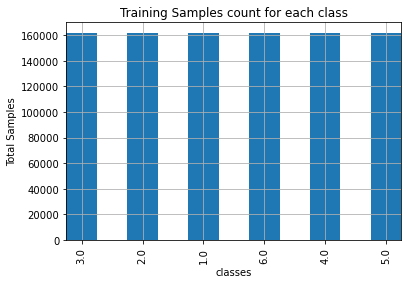

In [16]:
df_Train['Class_label'].value_counts().plot(kind='bar',
                                   title='Training Samples count for each class')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.ylabel('Total Samples')
plt.xlabel('classes')
plt.grid(True)
plt.autoscale(axis='x',tight=True)

In [17]:
df_Test=read_data_Test(file_path_test)
show_basic_dataframe_info(df_Test)
df_Test.head(5)

Number of columns in the dataframe: 9
Number of rows in the dataframe: 324000



,C1,C2,C3,C4,C5,C6,C7,C8,Class_label
0,-0.00003,0.00002,-0.00003,-0.00001,0.00000,0.00000,0.00001,-0.00001,1.00000
1,-0.00003,0.00002,-0.00003,-0.00001,0.00000,0.00000,0.00001,-0.00001,1.00000
2,-0.00003,0.00002,-0.00003,-0.00001,0.00000,0.00000,0.00001,-0.00001,1.00000
3,-0.00003,0.00002,-0.00003,-0.00001,0.00000,0.00000,0.00001,-0.00001,1.00000
4,-0.00003,0.00002,-0.00003,-0.00001,0.00000,0.00000,0.00001,-0.00001,1.00000


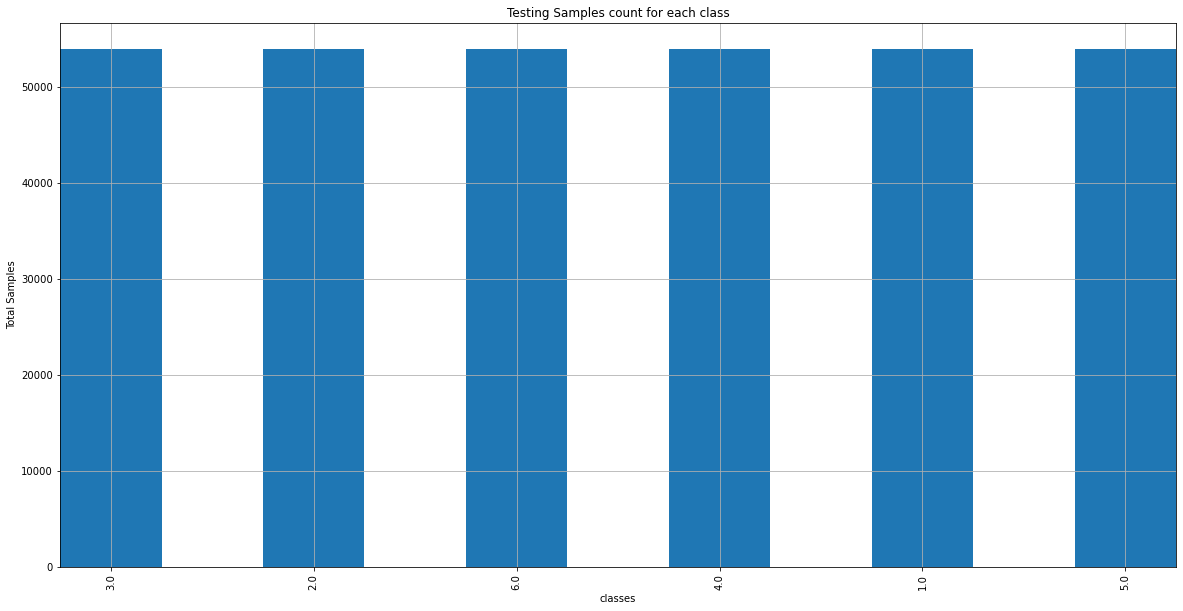

In [18]:
df_Test['Class_label'].value_counts().plot(kind='bar',
                                   title='Testing Samples count for each class')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size
plt.ylabel('Total Samples')
plt.xlabel('classes')
plt.grid(True)
plt.autoscale(axis='x',tight=True)

In [19]:
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df_Train[LABEL] = le.fit_transform(df_Train['Class_label'].values.ravel())
# df_Valid[LABEL] = le.fit_transform(df_Valid['Class_label'].values.ravel())
df_Test[LABEL] = le.fit_transform(df_Test['Class_label'].values.ravel())

In [20]:
pd.options.display.float_format = "{:,.5f}".format
df_Train.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,Class_label,ActivityEncoded
0,-0.00001,0.00000,-0.00001,0.00000,0.00000,-0.00001,-0.00001,0.00001,1.00000,0
1,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.00000,0
2,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.00000,0
3,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.00000,0
4,-0.00001,-0.00002,0.00000,-0.00001,-0.00001,-0.00001,-0.00003,-0.00002,1.00000,0


In [21]:
scaler = preprocessing.StandardScaler().fit(df_Train.iloc[:,0:N_FEATURES])

In [22]:
df_Train.iloc[:,0:N_FEATURES]=scaler.transform(df_Train.iloc[:,0:N_FEATURES])

In [23]:
pd.options.display.float_format = "{:,.5f}".format
df_Train.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,Class_label,ActivityEncoded
0,-0.00918,0.07347,-0.00537,0.03266,0.05739,0.00585,-0.00049,0.10120,1.00000,0
1,-0.00918,-0.07394,0.06717,-0.00515,0.02545,0.00585,-0.11263,-0.04816,1.00000,0
2,-0.00918,-0.07394,0.06717,-0.00515,0.02545,0.00585,-0.11263,-0.04816,1.00000,0
3,-0.00918,-0.07394,0.06717,-0.00515,0.02545,0.00585,-0.11263,-0.04816,1.00000,0
4,-0.00918,-0.07394,0.06717,-0.00515,0.02545,0.00585,-0.11263,-0.04816,1.00000,0


In [24]:
pd.options.display.float_format = "{:,.5f}".format
df_Test.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,Class_label,ActivityEncoded
0,-0.00003,0.00002,-0.00003,-0.00001,0.00000,0.00000,0.00001,-0.00001,1.00000,0
1,-0.00003,0.00002,-0.00003,-0.00001,0.00000,0.00000,0.00001,-0.00001,1.00000,0
2,-0.00003,0.00002,-0.00003,-0.00001,0.00000,0.00000,0.00001,-0.00001,1.00000,0
3,-0.00003,0.00002,-0.00003,-0.00001,0.00000,0.00000,0.00001,-0.00001,1.00000,0
4,-0.00003,0.00002,-0.00003,-0.00001,0.00000,0.00000,0.00001,-0.00001,1.00000,0


In [25]:
df_Test.iloc[:,0:N_FEATURES]=scaler.transform(df_Test.iloc[:,0:N_FEATURES])

In [26]:
pd.options.display.float_format = "{:,.5f}".format
df_Test.head(5)

,C1,C2,C3,C4,C5,C6,C7,C8,Class_label,ActivityEncoded
0,-0.11640,0.22089,-0.15047,-0.00515,0.05739,0.04570,0.11164,0.00163,1.00000,0
1,-0.11640,0.22089,-0.15047,-0.00515,0.05739,0.04570,0.11164,0.00163,1.00000,0
2,-0.11640,0.22089,-0.15047,-0.00515,0.05739,0.04570,0.11164,0.00163,1.00000,0
3,-0.11640,0.22089,-0.15047,-0.00515,0.05739,0.04570,0.11164,0.00163,1.00000,0
4,-0.11640,0.22089,-0.15047,-0.00515,0.05739,0.04570,0.11164,0.00163,1.00000,0


In [27]:
x_train, y_train = create_segments_and_labels(df_Train,TIME_PERIODS,STEP_DISTANCE,N_FEATURES,LABEL)
print('x_train shape: ', x_train.shape)
# print(x_train)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
print('num_time_periods',num_time_periods)
print('num_sensors',num_sensors)
num_classes = le.classes_.size
print('class_list',list(le.classes_))
# input_shape = (num_time_periods,num_sensors)
# print(input_shape)
input_shape = (num_time_periods,num_sensors)
#x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train[0].shape)
print('input_shape:', input_shape)
x_train = x_train.astype('float32')
# x_train = [torch.tensor(arr, dtype=torch.float32) for arr in x_train]
# y_train = y_train.astype('float32')
# print(y_train)
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print(y_train_hot)
# y_train_hot= [torch.tensor(arr, dtype=torch.uint8) for arr in y_train_hot]
print('New y_train shape: ', y_train_hot.shape)

x_train shape:  (647, 1500, 8)
647 training samples
y_train shape:  (647,)
num_time_periods 1500
num_sensors 8
class_list [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
x_train shape: (1500, 8)
input_shape: (1500, 8)
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]
New y_train shape:  (647, 6)


In [28]:
x_test, y_test = create_segments_and_labels(df_Test,TIME_PERIODS,STEP_DISTANCE,N_FEATURES,LABEL)
print('x_test shape: ', x_test.shape)
# print(x_train)
print(x_test.shape[0], 'testing samples')
print('y_test shape: ', y_test.shape)
# Set input_shape / reshape for Keras
#x_test = x_test.reshape(x_test.shape[0], input_shape)
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test_hot = np_utils.to_categorical(y_test, num_classes)

x_test shape:  (215, 1500, 8)
215 testing samples
y_test shape:  (215,)


In [29]:
# n_steps, n_length = 20, 25
# n_steps, n_length= 10, 50
# n_steps, n_length= 16, 32
n_steps, n_length = 30, 50
n_depth=8
x_train = x_train.reshape(x_train.shape[0], n_steps, n_length,n_depth)
print('x_train shape: ', x_train.shape)
# x_valid = x_valid.reshape(x_valid.shape[0], n_steps, n_length, n_depth)
# print('x_valid shape: ', x_valid.shape)
x_test = x_test.reshape(x_test.shape[0], n_steps, n_length,n_depth)
print('x_test shape: ', x_test.shape)
n_outputs = y_train_hot.shape[1]
print('n_outputs',n_outputs)

x_train shape:  (647, 30, 50, 8)
x_test shape:  (215, 30, 50, 8)
n_outputs 6


In [30]:
LABELS=[]
for i in range(1,n_outputs+1,1):
  LABELS.append (i)
print(LABELS)

[1, 2, 3, 4, 5, 6]


In [31]:
def step_decay(epoch):
  initial_lrate = 1e-4
  drop = 0.1
  epochs_drop = 70.0
  lrate = initial_lrate * tf.math.pow(drop,  
          tf.math.floor((1+epoch)/epochs_drop))
  return lrate

In [32]:
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [33]:
verbose, epochs, batch_size = 0, 200, 8

In [34]:
# naveen architecture
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=9, padding='same', kernel_initializer="he_normal",strides=2,kernel_regularizer=l1(1e-04)), \
                           input_shape=(n_steps,n_length,n_depth)))
model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
model.add(TimeDistributed(MaxPooling1D(pool_size=8,strides=2)))
model.add(TimeDistributed(Activation('tanh')))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=5,padding="same",kernel_initializer="he_normal",strides=2,kernel_regularizer=l1(1e-04))))
model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
model.add(TimeDistributed(Activation('tanh')))
model.add(TimeDistributed(Dropout(0.2093)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=5,padding="same",kernel_initializer="he_normal",strides=2,kernel_regularizer=l1(1e-04))))
model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
model.add(TimeDistributed(Activation('tanh')))
model.add(TimeDistributed(Dropout(0.2093)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3,padding="same",kernel_initializer="he_normal",strides=2,kernel_regularizer=l1(1e-04))))
model.add(TimeDistributed(BatchNormalization(epsilon=1e-06, momentum=0.95, weights=None)))
model.add(TimeDistributed(Activation('tanh')))
model.add(TimeDistributed(Dropout(0.2093)))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(Flatten()))
# model.add(Flatten())
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(200,return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(200,return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(Bidirectional(SimpleRNN(200,return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(Bidirectional(SimpleRNN(200,return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(BatchNormalization(epsilon=1e-05, momentum=0.9, weights=None))
# model.add(Bidirectional(SimpleRNN(200)))
# model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='tanh'))
# model.add(Dense(200, activation='tanh'))
model.add(BatchNormalization(epsilon=1e-05, momentum=0.9, weights=None))
model.add(Dense(n_outputs, activation='softmax'))

In [35]:
# olsson architecture
# model = Sequential()
# model.add(Conv2D(filters=64, kernel_size=(9,1), padding='same', kernel_initializer="he_normal",strides=(3,1), \
#                            input_shape=(n_steps,n_length,n_depth)))
# model.add(MaxPooling2D(pool_size=(8,1),strides=(2,1)))
# model.add(Activation('tanh'))
# model.add(Conv2D(filters=64, kernel_size=(5,1),padding="same",kernel_initializer="he_normal",strides=(2,1)))
# model.add(Activation('tanh'))
# model.add(Dropout(0.2093))
# model.add(Flatten())
# model.add(Dense(512, activation='tanh'))
# model.add(Dense(n_outputs, activation='softmax'))

In [36]:
adam=optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False)
checkpoint_filepath = '/media/naveen/nav/mat_codes/EMG_data_for_gestures-master/prep_no_prep/CNN25X20/checkpoint.hdf5'
# model.load_weights(checkpoint_filepath) 
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,verbose=1, monitor='val_accuracy',save_weights_only=True,save_best_only=True)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 25, 64)        4672      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 25, 64)        256       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 9, 64)         0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 9, 64)         0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 5, 64)         20544     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 5, 64)         256       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 5, 64)         0

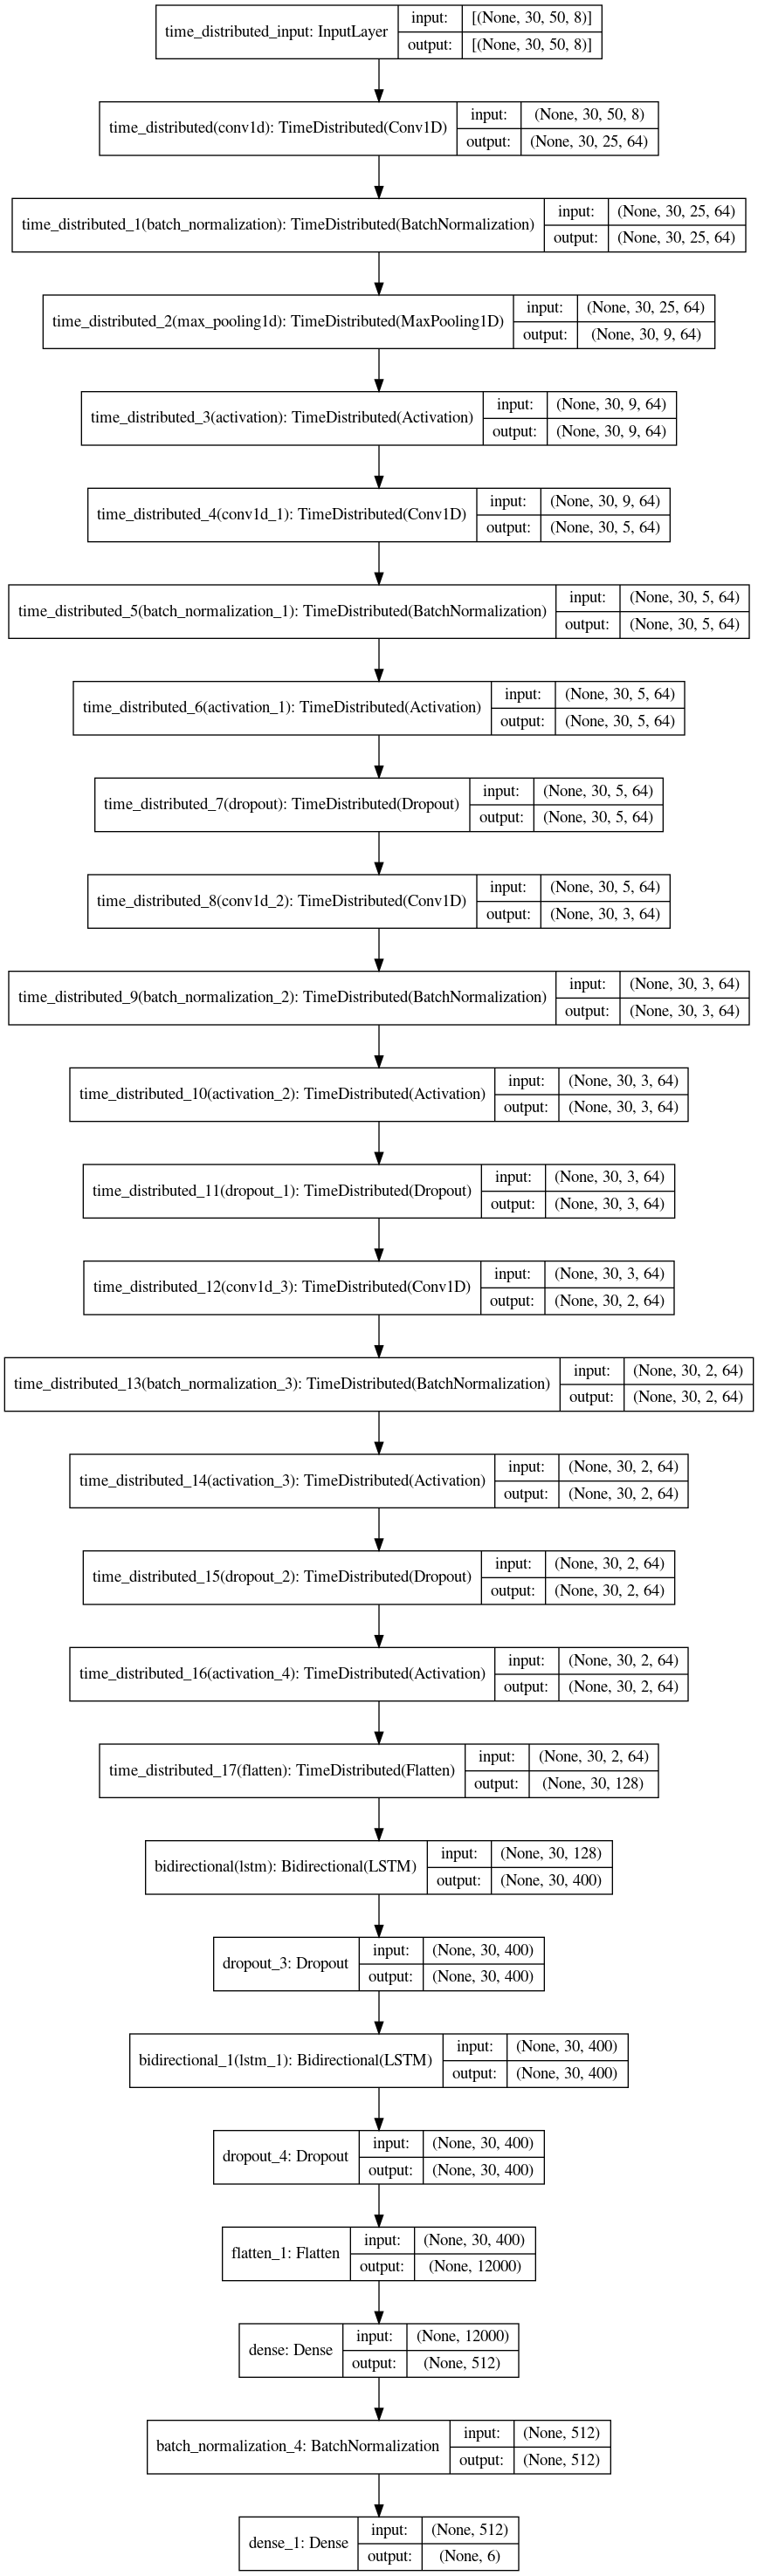

In [37]:
tf.keras.utils.plot_model(model, to_file='/media/naveen/nav/mat_codes/EMG_data_for_gestures-master/CNN25X20/Model1.png',show_shapes=True,show_layer_names=True,dpi=96)

In [38]:
# adam=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# sgd=tfa.optimizers.SGDW(weight_decay=0.0001,learning_rate=0.1, momentum=0.9, nesterov=False, name='SGDW')
# sgd=tf.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=False, name='SGD')
#     tf.keras.utils.plot_model(model, to_file='/media/naveen/nav/mat_codes/nina_DB1_codes/nina_prep_python/olsson/CNN20X10/Model1.png',show_shapes=True,show_layer_names=True,dpi=96)
csv_logger = CSVLogger('/media/naveen/nav/mat_codes/EMG_data_for_gestures-master/prep_no_prep/CNN25X20/CNN_nina_20X10.csv', append=True, separator=';')
history = model.fit(x_train, y_train_hot, epochs=epochs, batch_size=batch_size, callbacks=[csv_logger,checkpoint_callback,lrate,early],validation_data=(x_test, y_test_hot), verbose=1)
best_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
print('epoch_number',best_index+1)

Epoch 1/200
81/81 [==============================] - 18s 98ms/step - loss: 1.9563 - accuracy: 0.5250 - val_loss: 1.3931 - val_accuracy: 0.7023

Epoch 00001: val_accuracy improved from -inf to 0.70233, saving model to /media/naveen/nav/mat_codes/EMG_data_for_gestures-master/prep_no_prep/CNN25X20/checkpoint.hdf5
Epoch 2/200
81/81 [==============================] - 2s 25ms/step - loss: 1.3739 - accuracy: 0.6948 - val_loss: 1.0317 - val_accuracy: 0.7860

Epoch 00002: val_accuracy improved from 0.70233 to 0.78605, saving model to /media/naveen/nav/mat_codes/EMG_data_for_gestures-master/prep_no_prep/CNN25X20/checkpoint.hdf5
Epoch 3/200
81/81 [==============================] - 2s 25ms/step - loss: 1.2922 - accuracy: 0.7297 - val_loss: 1.0913 - val_accuracy: 0.7395

Epoch 00003: val_accuracy did not improve from 0.78605
Epoch 4/200
81/81 [==============================] - 2s 25ms/step - loss: 1.1276 - accuracy: 0.7550 - val_loss: 0.9794 - val_accuracy: 0.7814

Epoch 00004: val_accuracy did not

81/81 [==============================] - 2s 24ms/step - loss: 0.7324 - accuracy: 0.8803 - val_loss: 0.8080 - val_accuracy: 0.8884

Epoch 00037: val_accuracy did not improve from 0.88837
Epoch 38/200
81/81 [==============================] - 2s 25ms/step - loss: 0.7440 - accuracy: 0.8898 - val_loss: 0.7882 - val_accuracy: 0.8884

Epoch 00038: val_accuracy did not improve from 0.88837
Epoch 39/200
81/81 [==============================] - 2s 25ms/step - loss: 0.6721 - accuracy: 0.8951 - val_loss: 0.8772 - val_accuracy: 0.8837

Epoch 00039: val_accuracy did not improve from 0.88837
Epoch 40/200
81/81 [==============================] - 2s 24ms/step - loss: 0.6791 - accuracy: 0.9153 - val_loss: 0.7959 - val_accuracy: 0.9070

Epoch 00040: val_accuracy improved from 0.88837 to 0.90698, saving model to /media/naveen/nav/mat_codes/EMG_data_for_gestures-master/prep_no_prep/CNN25X20/checkpoint.hdf5
Epoch 41/200
81/81 [==============================] - 2s 25ms/step - loss: 0.6225 - accuracy: 0.9431 

81/81 [==============================] - 2s 24ms/step - loss: 0.4974 - accuracy: 0.9713 - val_loss: 0.7149 - val_accuracy: 0.9163

Epoch 00076: val_accuracy did not improve from 0.93023
Epoch 77/200
81/81 [==============================] - 2s 24ms/step - loss: 0.5229 - accuracy: 0.9725 - val_loss: 0.7216 - val_accuracy: 0.9256

Epoch 00077: val_accuracy did not improve from 0.93023
Epoch 78/200
81/81 [==============================] - 2s 24ms/step - loss: 0.4515 - accuracy: 0.9937 - val_loss: 0.7190 - val_accuracy: 0.9116

Epoch 00078: val_accuracy did not improve from 0.93023
Epoch 79/200
81/81 [==============================] - 2s 24ms/step - loss: 0.5035 - accuracy: 0.9767 - val_loss: 0.7264 - val_accuracy: 0.9163

Epoch 00079: val_accuracy did not improve from 0.93023
Epoch 80/200
81/81 [==============================] - 2s 24ms/step - loss: 0.4821 - accuracy: 0.9847 - val_loss: 0.7367 - val_accuracy: 0.9302

Epoch 00080: val_accuracy did not improve from 0.93023
Epoch 81/200
81/81

81/81 [==============================] - 2s 24ms/step - loss: 0.4764 - accuracy: 0.9726 - val_loss: 0.7400 - val_accuracy: 0.9116

Epoch 00117: val_accuracy did not improve from 0.93023
Epoch 118/200
81/81 [==============================] - 2s 24ms/step - loss: 0.4833 - accuracy: 0.9711 - val_loss: 0.7450 - val_accuracy: 0.9070

Epoch 00118: val_accuracy did not improve from 0.93023
Epoch 119/200
81/81 [==============================] - 2s 24ms/step - loss: 0.4638 - accuracy: 0.9865 - val_loss: 0.7445 - val_accuracy: 0.9163

Epoch 00119: val_accuracy did not improve from 0.93023
Epoch 120/200
81/81 [==============================] - 2s 24ms/step - loss: 0.4496 - accuracy: 0.9973 - val_loss: 0.7348 - val_accuracy: 0.9116

Epoch 00120: val_accuracy did not improve from 0.93023
Epoch 121/200
81/81 [==============================] - 2s 24ms/step - loss: 0.4383 - accuracy: 0.9933 - val_loss: 0.7278 - val_accuracy: 0.9116

Epoch 00121: val_accuracy did not improve from 0.93023
epoch_number 7

In [39]:
import datetime

In [40]:
print('train accuracy and validation accuracy', history.history['accuracy'][best_index], history.history['val_accuracy'][best_index])
model.load_weights(checkpoint_filepath) 
print(datetime.datetime.now())
_, testaccuracy = model.evaluate(x_test, y_test_hot, batch_size=batch_size, verbose=1)
print(datetime.datetime.now())
print('test_accuracy',testaccuracy)
# test_acc.append(testaccuracy)

train accuracy and validation accuracy 0.9644513130187988 0.930232584476471
2021-11-10 17:15:27.252763
27/27 [==============================] - 0s 8ms/step - loss: 0.7086 - accuracy: 0.9302
2021-11-10 17:15:27.527372
test_accuracy 0.930232584476471


In [41]:
model.save('/media/naveen/nav/mat_codes/EMG_data_for_gestures-master/prep_no_prep/CNN25X20/CNN_LSTM_nina_5X97')

INFO:tensorflow:Assets written to: /media/naveen/nav/mat_codes/EMG_data_for_gestures-master/prep_no_prep/CNN25X20/CNN_LSTM_nina_5X97/assets


INFO:tensorflow:Assets written to: /media/naveen/nav/mat_codes/EMG_data_for_gestures-master/prep_no_prep/CNN25X20/CNN_LSTM_nina_5X97/assets


history loss
history accuracy
history val_loss
history val_accuracy
history lr


NameError: name 'ax' is not defined

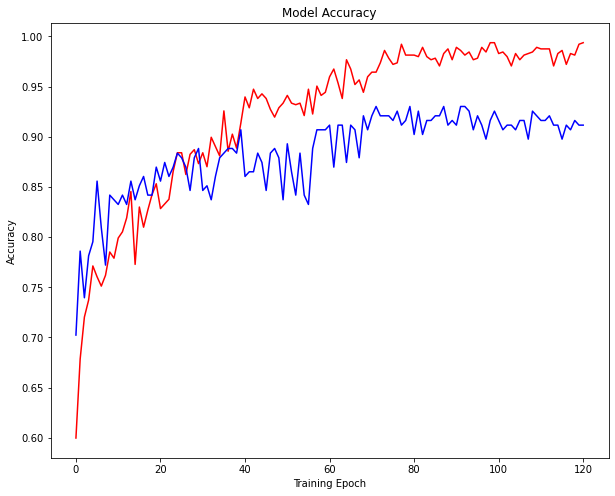

In [42]:
for i in history.history:
    print("history",i)
# facecolor='black'
DB1a=plt.figure(figsize=(10, 8),edgecolor='black')
# ax=figDB4.add_axes(("left", "bottom", "width", "height"))
# ax= DB1a.add_axes((1,1,1,1))
# ax.spines["top"].set_position(("outward", 0))
# ax.spines["bottom"].set_position(("data", 0))
# ax.spines["left"].set_position(("axes", 0))
# ax.spines["right"].set_position(("outward", 0))

# ax.spines["top"].set_color("black")
# ax.spines["left"].set_color("black")
# ax.spines["right"].set_color("black")
# ax.spines["bottom"].set_color("black")

# ax.spines["left"].set_bounds(-.5, .5)
# ax.spines["right"].set_linestyle("--")
# ax.spines["bottom"].set_linewidth(6)
# ax.spines["bottom"].set_capstyle("round")

# plt2.rcParams['figure.facecolor'] = 'white'
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')

# plt2.ylim(0)
# plt2.rcParams['figure.facecolor'] = 'white'

# ax = fig.add_axes((left, bottom, width, height))
ax.set(facecolor="white")
# ax.patch.set_alpha(1.0)
plt.ylim(0)
plt.legend()
plt.show()

In [ ]:
for i in history.history:
    print("history",i)
# facecolor='black'
# ax= figDB1.add_axes((1,1,1,1))
# ax.spines["top"].set_position(("outward", 0))
# ax.spines["bottom"].set_position(("data", 0))
# ax.spines["left"].set_position(("axes", 0))
# ax.spines["right"].set_position(("outward", 0))

# ax.spines["top"].set_color("black")
# ax.spines["left"].set_color("black")
# ax.spines["right"].set_color("black")
# ax.spines["bottom"].set_color("black") 

figDB1=plt.figure(figsize=(10, 8),edgecolor='black')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 28}

plt.rc('font', **font)

# SMALL_SIZE = 12
# MEDIUM_SIZE = 14
# BIGGER_SIZE = 18

# figBPR.suptitle('test title', fontsize=20)
#plt.rc('xlabel', fontsize=14, weight = 'bold')
#plt.rc('ylabel', fontsize=14, weight = 'bold')

# plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
# plt.rc('axes', labelsize=MEDIUM_SIZE )     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE, weight = 'bold')    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE )  # fontsize of the figure title

# ax=figDB1.add_axes(("left", "bottom", "width", "height"))
# ax= figDB1.add_axes((1,1,1,1))
# ax.spines["top"].set_position(("outward", 0))
# ax.spines["bottom"].set_position(("data", 0))
# ax.spines["left"].set_position(("axes", 0))
# ax.spines["right"].set_position(("outward", 0))

# ax.spines["top"].set_color("black")
# ax.spines["left"].set_color("black")
# ax.spines["right"].set_color("black")
# ax.spines["bottom"].set_color("black")

# ax.spines["left"].set_bounds(-.5, .5)
# ax.spines["right"].set_linestyle("--")
ax.spines["top"].set_linewidth(3)
ax.spines["top"].set_linestyle("-")
ax.spines["bottom"].set_linewidth(3)
ax.spines["bottom"].set_linestyle("-")
ax.spines["left"].set_linewidth(3)
ax.spines["left"].set_linestyle("-")
ax.spines["right"].set_linewidth(3)
ax.spines["right"].set_linestyle("-")
# ax.spines["bottom"].set_capstyle("round")

# plt2.rcParams['figure.facecolor'] = 'white'
plt.plot(history.history['loss'], 'r-', linewidth=3, label='Loss on training data')
plt.plot(history.history['val_loss'], 'b-', linewidth=3, label='Loss on validation data')
# plt.title('Loss curve for NinaPro DB1',fontsize=18, weight = 'bold')

plt.ylabel('Loss',fontsize=30, weight = 'bold')
plt.xlabel('no. of training epochs',fontsize=30, weight = 'bold')
# plt2.ylim(0)
# plt2.rcParams['figure.facecolor'] = 'white'

# ax = fig.add_axes((left, bottom, width, height))
ax.set(facecolor="white")
# ax.patch.set_alpha(1.0)
plt.ylim(0)
plt.legend()
plt.show()

In [ ]:
# figDB1.savefig('/media/naveen/nav/plots/UCI_sEMG_36_25X20.eps',transparent=False)
# figDB1.savefig('/media/naveen/nav/plots/NinaPro_DB1_25X20.pdf',transparent=False)

In [ ]:
model.load_weights(checkpoint_filepath) 
_, testaccuracy = model.evaluate(x_test, y_test_hot, batch_size=batch_size, verbose=1)
print('test_accuracy',testaccuracy)

In [ ]:
y_pred_train = model.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
#max_y_train = np.argmax(y_train, axis=1)
show_confusion_matrix(y_train, max_y_pred_train)
print(classification_report(y_train, max_y_pred_train))

In [ ]:
y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test_hot, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))